## I love to debug

In [419]:
import functools
import os
import time
from typing import List
import matplotlib.pyplot as plt
import cirq
import networkx as nx
import numpy as np
import qiskit
from mitiq import benchmarks, pec

from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeSherbrooke

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit import QuantumCircuit


In [420]:
backend= FakeSherbrooke()
qc = QuantumCircuit(2)
qc.cx(1,0)

pm = qiskit.transpiler.generate_preset_pass_manager(optimization_level=0, backend=backend)
transpiled_circuit = pm.run(qc)
transpiled_circuit.dsherbrooke_raw()




AttributeError: 'QuantumCircuit' object has no attribute 'dsherbrooke_raw'

In [ ]:
!pip list -- local

Package                           Version
--------------------------------- ------------------
aext-assistant                    4.1.0
aext-assistant-server             4.1.0
aext-core                         4.1.0
aext-core-server                  4.1.0
aext-panels                       4.1.0
aext-panels-server                4.1.0
aext-project-filebrowser-server   4.1.0
aext-share-notebook               4.1.0
aext-share-notebook-server        4.1.0
aext-shared                       4.1.0
aext-toolbox                      4.1.0
aiobotocore                       2.12.3
aiohappyeyeballs                  2.4.0
aiohttp                           3.10.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
alembic                           1.13.3
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-auth                     0.8.4
anaconda-catalogs                 0.2.0
anaconda-cli-base    

In [ ]:
print(FakeTorino.num_qubits)
print(FakeSherbrooke.num_qubits)

In [ ]:
ideal_backend = qiskit_aer.AerSimulator()
noisy_backend = FakeSherbrooke()
# Random seed for circuit generation.
seed: int = 1

# Display verbose output.
verbose: bool = False
# Give queue updates every this many seconds when running on hardware device.
verbose_update_time: int = 30

In [ ]:
def get_phys_qubits(n_qubits):
    ibm_sherbrooke_ordering = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 30, 29, 28, 27, 26, 25, 24, 
                            23, 22, 21, 20, 33, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 55, 68, 
                            67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 71, 77, 78, 79, 80, 81, 82, 83, 
                            84, 85, 86, 87, 93, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 
                            109, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126] # Up to 87 qubits
    
    return ibm_sherbrooke_ordering[: n_qubits]

In [ ]:
def get_layout(n_qubits):
    phys_qubits = get_phys_qubits(n_qubits)
    virt_qubits =[]
    for qubit_i in range(0,n_qubits):
        virt_qubits.append(qubit_i)
    layout =  dict(zip(phys_qubits, virt_qubits))
        
    return layout #keys: physical, values: virtual

In [ ]:
print(get_layout(15))

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 17: 13, 30: 14}


In [ ]:
def get_computer(n_qubits):
    layout = get_layout(n_qubits)
    phys_edges = noisy_backend.coupling_map.get_edges()
    virt_edges = []
    for edge_i in range(0, int(len(phys_edges)/2)):
        phys_edge = phys_edges[edge_i]
        try:
            virt_edge = (layout[phys_edge[0]],layout[phys_edge[1]])
        except:
            # print("skip: This edge is not included in our layout")
            meaningless=1
        virt_edges.append(virt_edge)
        
    # Make connectivity graph 
    computer = nx.DiGraph()
    computer.add_edges_from(virt_edges[:n_qubits - 1])

    # # Add reversed edges to computer graph.
    # # This is important to represent CNOT gates with target and control reversed.
    # computer = nx.to_directed(computer)
    return computer

In [ ]:
n_qubits = 6

layout = get_layout(n_qubits)
phys_edges = noisy_backend.coupling_map.get_edges()
computer= get_computer(n_qubits)
virt_edges = []
for virt_edge in computer.edges:
    virt_edges.append(virt_edge)

phys_edge_i = phys_edges[3]
virt_edge_i = virt_edges[3]

print(layout)
print(phys_edges)
print(virt_edges)
print(phys_edge_i)
print(virt_edge_i)
print(layout[phys_edge_i[1]])

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
EdgeList[(1, 0), (1, 2), (3, 2), (4, 3), (4, 15), (5, 4), (6, 5), (7, 6), (7, 8), (8, 9), (10, 9), (10, 11), (11, 12), (12, 13), (14, 0), (14, 18), (16, 8), (17, 12), (17, 30), (18, 19), (19, 20), (20, 33), (21, 20), (21, 22), (22, 15), (23, 22), (23, 24), (25, 24), (26, 16), (26, 25), (26, 27), (28, 27), (29, 28), (29, 30), (31, 30), (31, 32), (32, 36), (33, 39), (34, 24), (35, 28), (35, 47), (36, 51), (37, 38), (38, 39), (40, 39), (41, 40), (41, 53), (42, 41), (43, 34), (43, 42), (43, 44), (45, 44), (45, 46), (47, 46), (47, 48), (49, 48), (49, 50), (50, 51), (52, 37), (53, 60), (54, 45), (55, 49), (56, 52), (56, 57), (57, 58), (59, 58), (59, 60), (61, 60), (61, 62), (63, 62), (63, 64), (64, 54), (64, 65), (66, 65), (67, 66), (68, 55), (68, 67), (69, 68), (69, 70), (71, 58), (71, 77), (72, 62), (73, 66), (73, 85), (74, 70), (75, 76), (77, 76), (78, 77), (78, 79), (79, 91), (80, 79), (80, 81), (81, 72), (81, 82), (82, 83), (83, 84), (85, 84), (86, 8

In [ ]:
def execute(
    circuits: qiskit.QuantumCircuit | list[qiskit.QuantumCircuit],
    backend,
    shots: int,
    correct_bitstring: str,
    verbose: bool,
    ) -> List[float]:
    """Executes the input circuit(s) and returns ⟨A⟩, where A = |correct_bitstring⟩⟨correct_bitstring| for each circuit."""

    if not isinstance(circuits, list):
        circuits = [circuits]
    if verbose:
        # Calculate average number of CNOT gates per circuit.
        print(f"Executing {len(circuits)} circuit(s) on {backend}.")
        print(f"Average cnot count in circuits: {get_avg_cnot_count(circuits)}")

    # Store all circuits to run in list to be returned.
    to_run: list[qiskit.QuantumCircuit] = []

    for circuit in circuits:
        circuit_to_run = circuit.copy()
        circuit_to_run.measure_all()
        to_run.append(
            qiskit.transpile(
                circuit_to_run,
                backend=backend,
                initial_layout= get_phys_qubits(circuit.num_qubits),
                optimization_level=0,  # Otherwise RB circuits are simplified to empty circuits.
            )
        )

    if verbose:
        # Calculate average number of CNOT gates per compiled circuit.
        print(f"Average cnot count in compiled circuits: {get_avg_cnot_count(to_run)}")

    # Run and get counts.
    job = backend.run(
        to_run,
        # Reset qubits to ground state after each sample.
        init_qubits=True,
        shots=shots,
    )

    if len(circuits) == 1:
        return [job.result().get_counts().get(correct_bitstring, 0.0) / shots]
    return [
        count.get(correct_bitstring, 0.0) / shots for count in job.result().get_counts()
    ]

In [ ]:
def get_cnot_error(edge: tuple[int, int] = None) -> float:
    # cnot_error_prob = 0.01

    #translate virtual edge back to physical edge by inverting dictionary (layout)
    layout = get_layout(n_qubits)
    inv_layout = dict((v, k) for k, v in layout.items())
    print(inv_layout)
    phys_edge = (inv_layout[edge[0]],inv_layout[edge[1]])
    rz_error_q0 = noisy_backend.properties().gate_error("rz", qubits=phys_edge[0])
    sqrtx_error_q0 = noisy_backend.properties().gate_error("sx", qubits=phys_edge[0])
    rz_error_q1 = noisy_backend.properties().gate_error("rz", qubits=phys_edge[1])
    ecr_error = noisy_backend.properties().gate_error("ecr", qubits=[phys_edge[0],phys_edge[1]])
    x_error_q1 = noisy_backend.properties().gate_error("x", qubits=phys_edge[1])
    cnot_error_prob = 1 - (1-rz_error_q0)*(1-rz_error_q0)*(1-sqrtx_error_q0)*(1-rz_error_q0)*(1-rz_error_q0)*(1-ecr_error)*(1-rz_error_q1)*(1-x_error_q1)

    print(f"cnot_error_prob for edge {edge}: {cnot_error_prob}")
    return cnot_error_prob #return error prob for phys edge corresponding to input virt edge


def get_cnot_representation(edge: tuple[int, int]) -> pec.OperationRepresentation:
    cnot_circuit = cirq.Circuit(
        cirq.CNOT(
            cirq.NamedQubit(f"q_{str(edge[0])}"),
            cirq.NamedQubit(f"q_{str(edge[1])}"),
        )
    )

    rep_exact_prob = 1 - np.sqrt(1 - get_cnot_error(edge))
    return pec.represent_operation_with_local_depolarizing_noise(
        cnot_circuit,
        noise_level=rep_exact_prob,
    )


def get_representations(computer: nx.Graph) -> list[pec.OperationRepresentation]:
    return [get_cnot_representation(edge) for edge in computer.edges]

In [ ]:
# Hardware backend device type. Supported types are currently "ibmq" but more could be added.
hardware_type: str = "FakeSherbrooke"

backend = {
    "ibmq": "ibm_sherbrooke",
}.get(hardware_type)

In [ ]:
local_seed = 10**6 * depth + 10**3 * seed + 3

circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
        nlayers=depth,
        two_qubit_gate_prob=1.0,
        connectivity_graph=computer,
        two_qubit_gate_name="CNOT",
        seed=seed,
        return_type="qiskit",
    )
# Reversed because Qiskit is wrong endian.
correct_bitstring = "".join(map(str, correct_bitstring[::-1]))

(true_value,) = execute(circuit,
    ideal_backend,
    shots,
    correct_bitstring,
    verbose=verbose,
)

(noisy_value,) = execute(circuit,
    noisy_backend,
    shots,
    correct_bitstring,
    verbose=verbose,
)

pec_executor = functools.partial(
        execute,
        backend=noisy_backend,
        shots=shots // num_samples,
        correct_bitstring=correct_bitstring,
        verbose=verbose,
    )
pec_value = pec.execute_with_pec(
        circuit,
        pec_executor,
        representations=get_representations(computer),
        num_samples=num_samples,
        random_state=local_seed,
    )

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
cnot_error_prob for edge (1, 0): 0.00797977377601633
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
cnot_error_prob for edge (1, 2): 0.00936458025346687
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
cnot_error_prob for edge (3, 2): 0.009643463251089113
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
cnot_error_prob for edge (4, 3): 0.007737838927345586


C:\Users\munkr\AppData\Roaming\Python\Python312\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(0.5π)───.
  warnings.warn(
C:\Users\munkr\AppData\Roaming\Python\Python312\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Y───.
  warnings.warn(
C:\Users\munkr\AppData\Roaming\Python\Python312\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_2: ───X^-0.5───.
  warnings.warn(
C:\Users\munkr\AppData\Roaming\Python\Python312\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_3: ───X^0.5───.
  warnings.warn(
C:\Users\munkr\AppData\Roaming\Python\Python312\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_4: ───Ry(0.5π)───.
  warnings.warn(
C:\Users\munkr\AppData\Roaming\Python\Python312\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^-0.5───.
  warnings.warn(


In [ ]:
# Rebecca learns basic plotting skills
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob # For timestamps in files
import re # For plot name stuff 
import time 

In [ ]:
# Generic data
generic_ideal_vals = np.genfromtxt("C:\\Users\\munkr\\Documents\\GitHub\\EE522_25_3\\Notebooks\\Generic_PEC_mirror_nqubits_2_shots_10000_trials_10_Test_Depths\\true_values2025-05-19_19-05-16.txt", delimiter = " ")
generic_ideal_avgs = np.average(generic_ideal_vals, axis=1)

generic_raw_vals = np.genfromtxt("C:\\Users\\munkr\\Documents\\GitHub\\EE522_25_3\\Notebooks\\Generic_PEC_mirror_nqubits_2_shots_10000_trials_10_Test_Depths\\noisy_values2025-05-19_19-05-16.txt", delimiter = " ")
generic_raw_avgs = np.average(generic_raw_vals, axis=1)
generic_raw_stds = np.std(generic_raw_vals, axis=1, ddof=1)

generic_pec_vals = np.genfromtxt("C:\\Users\\munkr\\Documents\\GitHub\\EE522_25_3\\Notebooks\\Generic_PEC_mirror_nqubits_2_shots_10000_trials_10_Test_Depths\\pec_values2025-05-19_19-05-16.txt", delimiter = " ")
generic_pec_avgs = np.average(generic_pec_vals, axis=1)
generic_pec_stds = np.std(generic_pec_vals, axis=1, ddof=1)

generic_depths = np.arange(0,len(generic_ideal_vals))

print(generic_ideal_vals)

# Sherbrooke data
sherbrooke_ideal_vals = np.genfromtxt("C:\\Users\\munkr\\Documents\\GitHub\\EE522_25_3\\Notebooks\\Sherbrooke_PEC_mirror_nqubits_2_shots_10000_trials_10_Test_Depths\\true_values2025-05-14_15-52-13.txt", delimiter = " ")
sherbrooke_ideal_avgs = np.average(sherbrooke_ideal_vals, axis=1)

sherbrooke_raw_vals = np.genfromtxt("C:\\Users\\munkr\\Documents\\GitHub\\EE522_25_3\\Notebooks\\Sherbrooke_PEC_mirror_nqubits_2_shots_10000_trials_10_Test_Depths\\noisy_values2025-05-14_15-52-13.txt", delimiter = " ")
sherbrooke_raw_avgs = np.average(sherbrooke_raw_vals, axis=1)
sherbrooke_raw_stds = np.std(sherbrooke_raw_vals, axis=1, ddof=1)

sherbrooke_pec_vals = np.genfromtxt("C:\\Users\\munkr\\Documents\\GitHub\\EE522_25_3\\Notebooks\\Sherbrooke_PEC_mirror_nqubits_2_shots_10000_trials_10_Test_Depths\\pec_values2025-05-14_15-52-13.txt", delimiter = " ")
sherbrooke_pec_avgs = np.average(sherbrooke_pec_vals, axis=1)
sherbrooke_pec_stds = np.std(sherbrooke_pec_vals, axis=1, ddof=1)

sherbrooke_depths = np.arange(0,len(sherbrooke_ideal_avgs))


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


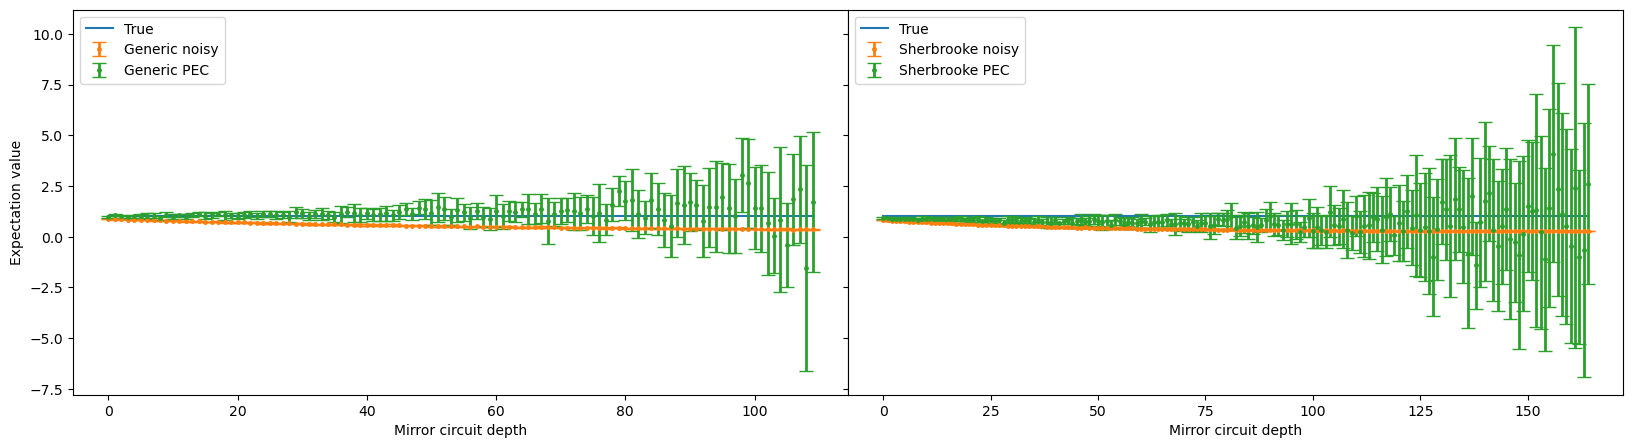

In [446]:
fig =plt.figure()
gs = fig.add_gridspec(1,2, hspace=0, wspace =0)
(ax1, ax2) = gs.subplots(sharey=True)

# gs = fig.add_gridspec(2,1, hspace=0, wspace =0)
# (ax1, ax2) = gs.subplots(sharex = True)

fig.set_figwidth(20)
fig.set_figheight(5)
kwargs = {"capsize": 5, "lw": 2}

ax1.plot(generic_depths, generic_ideal_avgs, label = "True")
ax1.errorbar(generic_depths, generic_raw_avgs, yerr= generic_raw_stds, label = "Generic noisy", **kwargs, fmt='o', ms=2.5)
ax1.errorbar(generic_depths, generic_pec_avgs, yerr= generic_pec_stds, label = "Generic PEC", **kwargs, fmt='o', ms=2.5)
ax1.set_xlabel("Mirror circuit depth")
ax1.set_ylabel("Expectation value")
ax1.legend(loc = "upper left")

ax2.plot(sherbrooke_depths, sherbrooke_ideal_avgs, label = "True")
ax2.errorbar(sherbrooke_depths, sherbrooke_raw_avgs, yerr= sherbrooke_raw_stds, label = "Sherbrooke noisy", **kwargs, fmt='o', ms=2.5)
ax2.errorbar(sherbrooke_depths, sherbrooke_pec_avgs, yerr= sherbrooke_pec_stds, label = "Sherbrooke PEC", **kwargs, fmt='o', ms=2.5)
ax2.set_xlabel("Mirror circuit depth")
ax2.legend(loc = "upper left")

for ax in fig.get_axes():
    ax.label_outer()